## Objective

#### NLP sentiment classification on news headlines
Using APIs or a little webscraping to harvest some new test data that you will manually label the new headlines as negative/positive and then see how your model does on those headlines.

#### Dataset:
[Sentiment Analysis for Financial News](https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news)

## Libraries

In [202]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# NLTK - Stopwords:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from gensim.models.doc2vec import TaggedDocument
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

#to see the entire column width:
pd.set_option('display.max_colwidth', -1)

### Imoport Data

In [95]:
df = pd.read_csv('all-data.csv', names = ['Sentiment', 'Headline'], 
                 encoding='latin-1')
df = df.sample(frac=1).reset_index(drop=True) # Shuffling the data in case there's an ordering bias
display(df.head())
print("Shape:", df.shape, "\n\n")
print(df.info())

,Sentiment,Headline
0,positive,"The agreement will provide The Switch with double the converter capacity , whilst opening up further manufacturing locations in China ."
1,neutral,"Panostaja treats its negotiating partners , such as entrepreneurs selling their life s work and newcomer entrepreneurs seeking a career , fairly , justly and according to the law ."
2,negative,In February the Elcoteq group sold its St Petersburg facility ; according to unconfirmed information the reason could have been supply problems because of the Russian customs service .
3,positive,"Rinkuskiai raised the sales by 18.1 percent , to 1.37 million liters , while the sales of Kauno Alus grew by 14.3 percent , to 960,000 liters ."
4,neutral,"Unit prices for straddle carriers vary between EUR700 ,000 and EUR900 ,000 , the company added ."


Shape: (4846, 2) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4846 non-null   object
 1   Headline   4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB
None


In [96]:
# Look at the instances of each sentiment
df.Sentiment.value_counts()

neutral     2879
positive    1363
negative    604 
Name: Sentiment, dtype: int64

#### Visualize the data

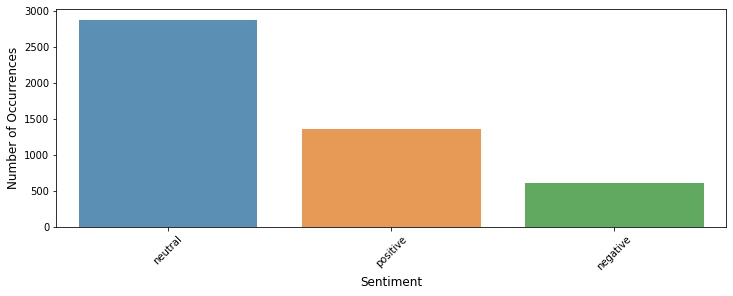

In [97]:
cnt_pro = df['Sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(rotation=45)
plt.show();

### Clean the Data

In [98]:
# Convert the string in the 'Sentiment' column to numeric form
Sentiment = {'positive': 0, 'neutral': 1, 'negative': 2}

In [99]:
# traversing through Sentiment column and writing values where key matches
df.Sentiment = [sentiment[item] for item in df.Sentiment] 
df.head(10)

,Sentiment,Headline
0,0,"The agreement will provide The Switch with double the converter capacity , whilst opening up further manufacturing locations in China ."
1,1,"Panostaja treats its negotiating partners , such as entrepreneurs selling their life s work and newcomer entrepreneurs seeking a career , fairly , justly and according to the law ."
2,2,In February the Elcoteq group sold its St Petersburg facility ; according to unconfirmed information the reason could have been supply problems because of the Russian customs service .
3,0,"Rinkuskiai raised the sales by 18.1 percent , to 1.37 million liters , while the sales of Kauno Alus grew by 14.3 percent , to 960,000 liters ."
4,1,"Unit prices for straddle carriers vary between EUR700 ,000 and EUR900 ,000 , the company added ."
5,0,`` The acquisition of Elektros Pavara completes KONE 's market expansion strategy in the Baltic Countries .
6,1,The opening of the portal is part of the expansion strategy of Alma Media 's Marketplaces business unit .
7,0,"According to Sepp+Ænen , the new technology UMTS900 solution network building costs are by one-third lower than that of the building of 3.5 G networks , operating at 2,100 MHz frequency ."
8,1,"The gross area of the Innova 2 project will be about 10,000 sq m ( 107,600 sq ft ) ."
9,0,It will focus on improving its profitability next year by streamlining operations .


#### Stopwords:
Remove words from strings that have no unique information ('is','an','the).

In [106]:
#nltk.download('stopwords')

stop = set(stopwords.words('english'))
stop.add("'s")
for item in string.punctuation:
    stop.add (item)
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

df['Headline'] = df['Headline'].map(remove_stopwords)

In [107]:
#check
df.head()

,Sentiment,Headline
0,0,agreement provide switch double converter capacity whilst opening manufacturing locations china
1,1,panostaja treats negotiating partners entrepreneurs selling life work newcomer entrepreneurs seeking career fairly justly according law
2,2,february elcoteq group sold st petersburg facility according unconfirmed information reason could supply problems russian customs service
3,0,"rinkuskiai raised sales 18.1 percent 1.37 million liters sales kauno alus grew 14.3 percent 960,000 liters"
4,1,"unit prices straddle carriers vary eur700 ,000 eur900 ,000 company added"


#### Lemmatization:
Lemmatization is the process of grouping together the different inflected forms of a word so they can be analysed as a single item. [Lemmatization](https://www.geeksforgeeks.org/python-lemmatization-with-nltk/)

In [108]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [112]:
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    text = [wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text.split()]
    return " ".join(text)

df['Headline'] = df['Headline'].map(lemmatize)

In [113]:
#check
df.head()

,Sentiment,Headline
0,0,agreement provide switch double converter capacity whilst opening manufacturing location china
1,1,panostaja treat negotiate partner entrepreneur sell life work newcomer entrepreneur seek career fairly justly accord law
2,2,february elcoteq group sell st petersburg facility accord unconfirmed information reason could supply problem russian custom service
3,0,"rinkuskiai raise sale 18.1 percent 1.37 million liter sale kauno alus grow 14.3 percent 960,000 liter"
4,1,"unit price straddle carrier vary eur700 ,000 eur900 ,000 company add"


WordCloud to see the commonly used words

In [200]:
#!pip install wordcloud

In [195]:
# Separating out the categories
pos = df.Headline[df.Sentiment[df.Sentiment== 1].index]
neg = df.Headline[df.Sentiment[df.Sentiment== 0].index]

In [196]:
def wordcloud(dataset):
    plt.figure(figsize = (18,24)) # Text Reviews with positive Ratings
    wordcloud = WordCloud(min_font_size = 3,  max_words = 2500 , width = 1000, 
                          height = 600,
                          collocations=False).generate(" ".join(dataset))
    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show();

def show_wordclouds():
    print ('Positive Sentiment Wordcloud:')
    wordcloud(pos)
    
    print ('Negative Sentiment Wordcloud:')
    wordcloud(neg)
    

Positive Sentiment Wordcloud:


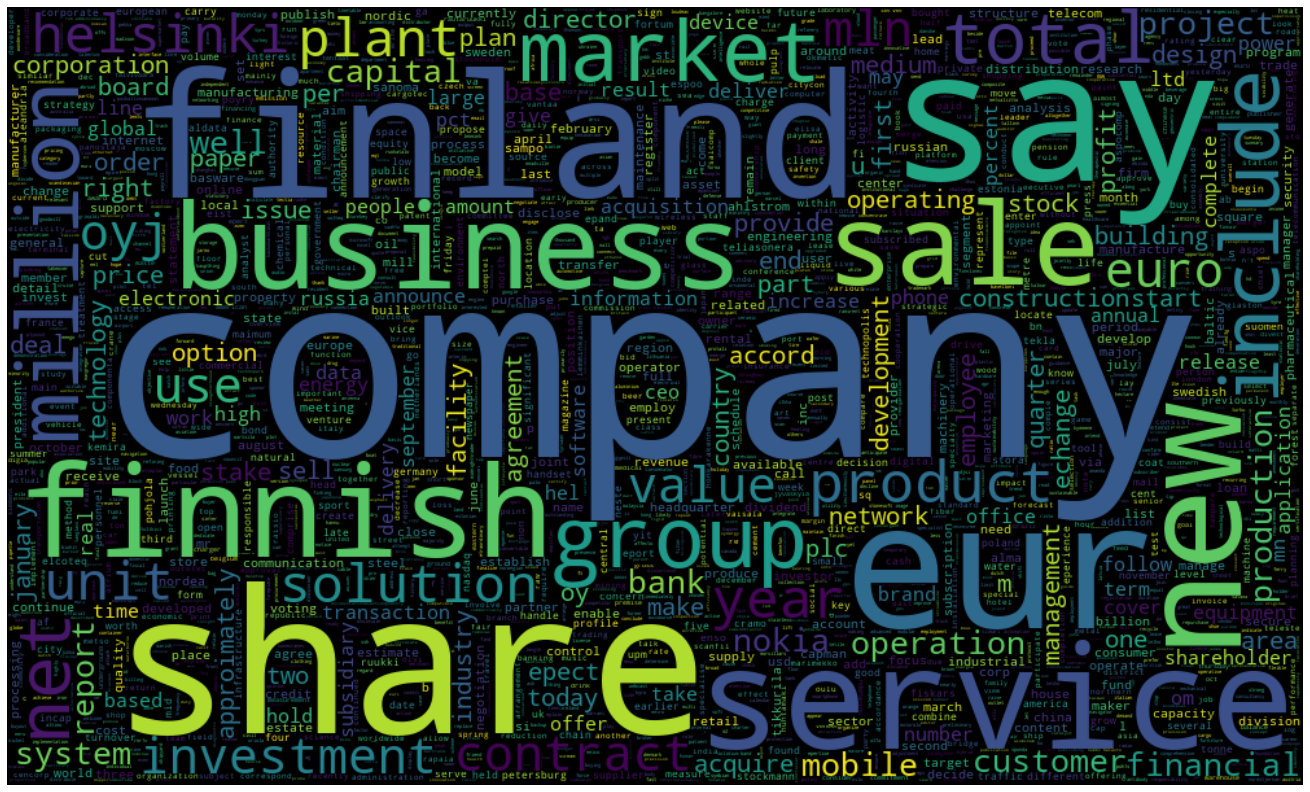

Negative Sentiment Wordcloud:


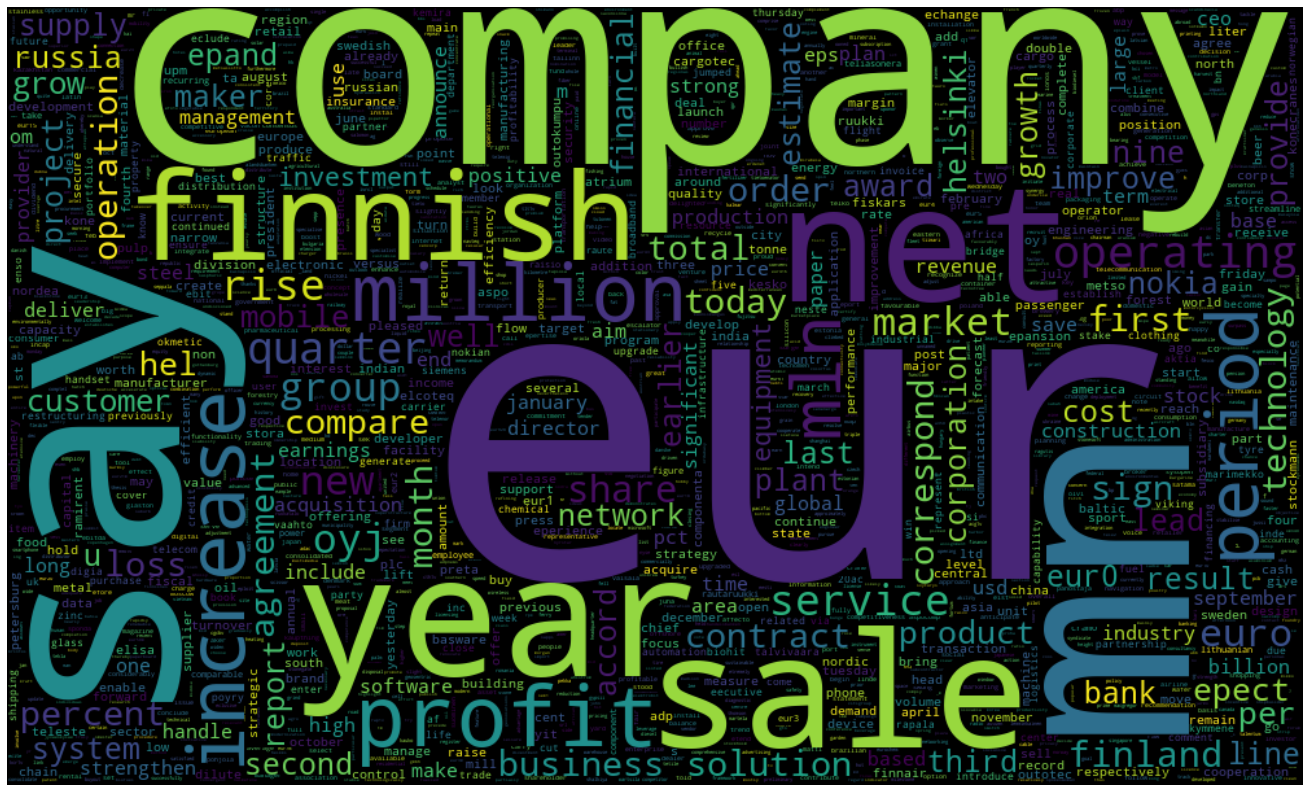

In [203]:
show_wordclouds()

Process the text to convert text to lower-case strip punctuations and symbols etc.

In [116]:
from bs4 import BeautifulSoup
import re

def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Headline'] = df['Headline'].apply(cleanText)

#### Counter

In [148]:
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

In [151]:
text = df.Headline
counter = counter_word(text)

In [152]:
len(counter)

10055

In [153]:
num_words = len(counter)

### Train/Test Split

In [119]:
train, test = train_test_split(df, test_size=0.000001 , random_state=42)

In [163]:
headlines = []
labels = []

for row in range(len(df)):
    headlines.append(df['Headline'][row])
    labels.append(df['Sentiment'][row])

In [165]:
# Setting the training ratio
training_size = int(df.shape[0] * .8) 

# Train Test Split:
# Already shuffled, so we're good to go
training_headlines = headlines[0:training_size]
testing_headlines = headlines[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [166]:
# Checking on a few of the headlines:
display(training_headlines[:3])
display(training_labels[:3])

['agreement provide switch double converter capacity whilst opening manufacturing location china',
 'panostaja treat negotiate partner entrepreneur sell life work newcomer entrepreneur seek career fairly justly accord law',
 'february elcoteq group sell st petersburg facility accord unconfirmed information reason could supply problem russian custom service']

[0, 1, 2]

### Tokenizer 
Tokenizing involoves splitting sentances and words from the body of the text
The use of a tokenizer creates a number coded to each word thereby allowing 
the neural network to build patterns and learn meaning.

In [120]:
# function to tokenize text

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens

In [130]:
# apply the splits to the tokenizer

# Gensim is a Python library for topic modeling, document indexing and Similarity retrieval with large corpora.
#[Gensim](https://pypi.org/project/gensim/)
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Headline']), tags=[r.Sentiment]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Headline']), tags=[r.Sentiment]), axis=1)

In [136]:
# set the maximum words to be used
max_features = 500000

# set the maximum words in each headline
max_sequence_length = 50

tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Headline'].values)
X = tokenizer.texts_to_sequences(df['Headline'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))


Found 4846 unique tokens.


In [139]:
# check the shape of data tensor:
X = tokenizer.texts_to_sequences(df['Headline'].values)
X = pad_sequences(X, maxlen=max_sequence_length)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (4846, 50)


In [169]:
embedding_dim = 32
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [171]:
# Initializing the fitting the tokenizer:
tokenizer = Tokenizer(num_words = num_words, oov_token = oov_tok)
tokenizer.fit_on_texts(training_headlines)
# Initializing the Word Index:
word_index = tokenizer.word_index
# Padding and Sequencing the Training Set:
training_sequences = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(training_sequences, maxlen = max_length,
                               padding = padding_type, 
                               truncating = trunc_type)
# Padding and Sequencing the Testing Set:
testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, 
                               padding = padding_type, 
                               truncating = trunc_type)


In [172]:
# Switch to Numpy Array
# Necessary for the ANN to read the data
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [173]:
print ('Padded and Tokenized Headline:\n', training_padded[3])
print ('\nThe actual headline:\n', df.Headline[3])
print ('\nLabel:\n', training_labels[3])

Padded and Tokenized Headline:
 [2603  537    6  212    8   75    8  735   12  614    6 2604 1756  157
  162   19   75 3741   40  614    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]

The actual headline:
 rinkuskiai raise sale 18.1 percent 1.37 million liter sale kauno alus grow 14.3 percent 960,000 liter

Label:
 0


In [174]:
# train
train_tagged.values

array([TaggedDocument(words=['april', '2005', 'neste', 'separate', 'parent', 'company', 'finnish', 'energy', 'company', 'fortum', 'become', 'list', 'helsinki', 'stock', 'echange'], tags=[1]),
       TaggedDocument(words=['growth', 'strong', 'f-secure', 'operator', 'isps', 'mobile', 'operator', 'cable', 'operator', 'business'], tags=[0]),
       TaggedDocument(words=['liquid', 'handle', 'product', 'include', 'electronic', 'mechanical', 'pipette', 'disposable', 'tip', 'well', 'pipette', 'maintenance', 'calibration', 'service', 'research', 'institution', 'healthcare', 'industrial', 'laboratory'], tags=[1]),
       ...,
       TaggedDocument(words=['transaction', 'epect', 'finalize', 'dec', '2009'], tags=[1]),
       TaggedDocument(words=['current', 'position', 'manty', 'work', 'since', '1996'], tags=[1]),
       TaggedDocument(words=['finnish', 'cutlery', 'hand', 'tool', 'maker', 'fiskars', 'oyj', 'abp', 'hel', 'fisa', 'say', 'today', 'net', 'profit', 'rise', 'eur', '24.1', 'million', 'us

### Model 1 (Hidden Layer)

In [159]:
embedding_dim = 32

model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=64))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2)) # Optional Regularization
model.add(Dense(1, activation='sigmoid'))

# Slower learning rate worked better as it kept the learning more stable
#opt = keras.optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer='adam', 
              metrics=['accuracy']) # Orig code

In [176]:
num_epochs = 50
# After 5 epochs of validation loss not improving, the model will stop.
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs,
                    batch_size = 10,
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 1, callbacks=[es])

Epoch 1/50
388/388 [==============================] - 2s 5ms/step - loss: 0.4641 - accuracy: 0.5913 - val_loss: 0.4005 - val_accuracy: 0.5996
Epoch 2/50
388/388 [==============================] - 2s 5ms/step - loss: 0.4198 - accuracy: 0.5973 - val_loss: 0.3945 - val_accuracy: 0.6001
Epoch 3/50
388/388 [==============================] - 2s 5ms/step - loss: 0.3969 - accuracy: 0.6023 - val_loss: 0.3927 - val_accuracy: 0.5988
Epoch 4/50
388/388 [==============================] - 2s 5ms/step - loss: 0.3696 - accuracy: 0.6037 - val_loss: 0.3941 - val_accuracy: 0.5988
Epoch 5/50
388/388 [==============================] - 2s 5ms/step - loss: 0.3520 - accuracy: 0.6038 - val_loss: 0.4003 - val_accuracy: 0.5993
Epoch 6/50
388/388 [==============================] - 2s 5ms/step - loss: 0.3308 - accuracy: 0.6042 - val_loss: 0.4110 - val_accuracy: 0.5992
Epoch 7/50
388/388 [==============================] - 2s 5ms/step - loss: 0.3194 - accuracy: 0.6044 - val_loss: 0.4105 - val_accuracy: 0.5992
Epoch 

### Functions for Model Evaluation:

In [177]:
def model_eval(history):
    pd.DataFrame(history.history).plot(figsize = (12,8)) 
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

def model_metrics(model):
    train_acc = model.evaluate(training_padded, training_labels, verbose=0)
    test_acc = model.evaluate(testing_padded, testing_labels, verbose=0)
    print('Train Loss:', "{:.3%}".format(train_acc[0]))
    print('Train Accuracy:', "{:.3%}".format(train_acc[1]))
    print('Test Loss:', "{:.3%}".format(test_acc[0]))
    print('Test Accuracy:', "{:.3%}".format(test_acc[1]))
    
# Made up some easy headlines to see if the ANN works
def easy_headlines():
    sentence = ["stock rise rapid for tesla", 
                "apple factory shut down, lay off hundred employee",
                "average day of return for microsoft"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))
    
# Random headlines from NYT Business  (post stopword removal and lemmatization) 
# This may be a bit trickier for the network
def harder_headlines():
    sentence = ["snowflake more  double  debut  wall street embrace tech ipos", 
                "europe economic revival imperil raising the specter grind downturn",
                "fed debate next step after shifting approach to rate setting"]
    sequences = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequences, maxlen=max_length, 
                           padding=padding_type, 
                           truncating=trunc_type)
    for headline in sentence:    
        print (headline)
    print(model.predict(padded))

def test_headlines():
    print('Easier Headlines:')
    easy_headlines()
    print ('\n')
    print ('Realistic Headlines:')
    harder_headlines()

In [178]:
model_metrics(model)

Train Loss: 30.066%
Train Accuracy: 60.502%
Test Loss: 40.929%
Test Accuracy: 59.922%


In [179]:
test_headlines()

Easier Headlines:
stock rise rapid for tesla
apple factory shut down, lay off hundred employee
average day of return for microsoft
[[[0.9118428 ]
  [0.13337815]
  [0.95264506]
  [0.9997592 ]
  [0.85545903]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]
  [0.8440093 ]]

 [[0.7815234 ]
  [1.        ]
  [1.        ]
  [1.        ]
  [1.        ]
  [0.9999746 ]
  [0.85545903]
  [1.       

### Model 2 (LSTM):

In [191]:
model = Sequential()
model.add(Embedding(num_words, embedding_dim, input_length=max_length))
model.add(LSTM(64, dropout = 0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy']) # Orig code

In [192]:
num_epochs = 50
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(training_padded, training_labels, 
                    epochs=num_epochs,
                    batch_size = 24,
                    validation_data=(testing_padded, testing_labels), 
                    verbose= 1, callbacks = [es])

Epoch 1/50
162/162 [==============================] - 5s 32ms/step - loss: 0.4687 - accuracy: 0.5916 - val_loss: 0.4144 - val_accuracy: 0.5979
Epoch 2/50
162/162 [==============================] - 5s 30ms/step - loss: 0.3576 - accuracy: 0.6370 - val_loss: 0.3756 - val_accuracy: 0.6351
Epoch 3/50
162/162 [==============================] - 5s 29ms/step - loss: 0.3535 - accuracy: 0.6530 - val_loss: 0.4231 - val_accuracy: 0.5979
Epoch 4/50
162/162 [==============================] - 5s 31ms/step - loss: 0.4398 - accuracy: 0.5931 - val_loss: 0.4129 - val_accuracy: 0.5979
Epoch 5/50
162/162 [==============================] - 5s 31ms/step - loss: 0.4408 - accuracy: 0.5931 - val_loss: 0.4090 - val_accuracy: 0.5979
Epoch 6/50
162/162 [==============================] - 5s 31ms/step - loss: 0.4181 - accuracy: 0.5931 - val_loss: 0.3660 - val_accuracy: 0.5979
Epoch 7/50
162/162 [==============================] - 5s 31ms/step - loss: 0.3398 - accuracy: 0.6522 - val_loss: 0.3905 - val_accuracy: 0.6103

In [193]:
model_metrics(model)

Train Loss: 46.564%
Train Accuracy: 59.314%
Test Loss: 44.341%
Test Accuracy: 59.794%


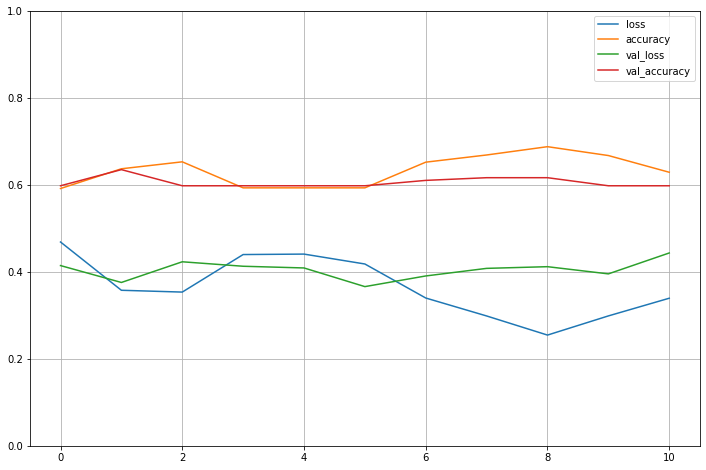

In [194]:
model_eval(history)